# CSC 365 Lab 8

Author: Andrew Cheung  
Email: acheun29@calpoly.edu

NOTE: The code requires a file named "account.info" with the username on the first line and password on the second line to connect to mysql.labthreesixfive.com.

# Question 1: For each region, how many "spontaneous" and "organized" events took place?

I wanted to know whether spontaneous or organized events of urban unrest were more common in each region. Spontaneous events had the substring "spontaneous" in the problem type, and organized events had "organized" in the problem type. In the query, I used a subquery to select the number of events of each type for each region, and joined the resulting relations on the region. Then, I plotted the numbers of events on a double bar graph.

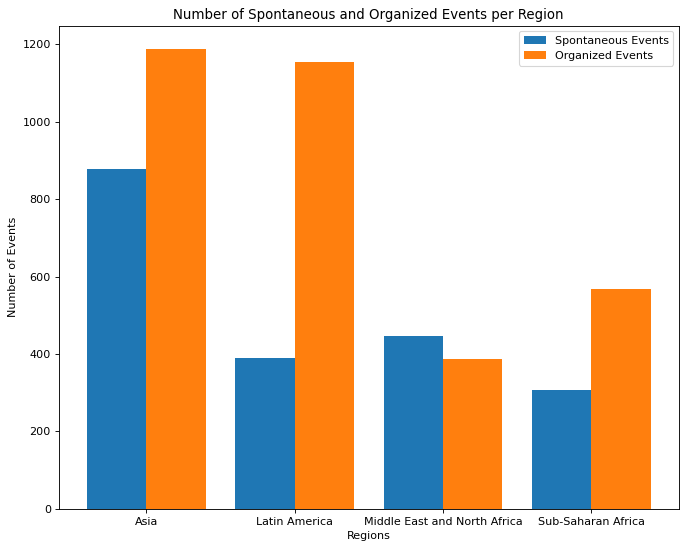



                          Region  SpontaneousEvents  OrganizedEvents
0                          Asia                879             1189
1                 Latin America                389             1155
2  Middle East and North Africa                446              386
3            Sub-Saharan Africa                307              569


In [8]:
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
import numpy as np
import pandas as pd


def execute_sql(cursor):
    cursor.execute("USE LAB8;")

    cursor.execute("WITH sp AS "
                        "(SELECT Countries.Region, COUNT(*) AS Spontaneous "
                        "FROM EventActors AS ea, Events AS e, "
                            "ProblemTypes AS pt, Cities, Countries "
                        "WHERE ea.eventID = e.eventID "
                            "AND e.Ptype = pt.Ptype "
                            "AND e.City = Cities.CityId "
                            "AND Cities.Country = Countries.ISO3 "
                            "AND INSTR(pt.ProblemType, 'Spontaneous') > 0 "
                        "GROUP BY Countries.Region), "
                    "org AS "
                        "(SELECT Countries.Region, COUNT(*) AS Organized "
                        "FROM EventActors AS ea, Events AS e, "
                            "ProblemTypes AS pt, Cities, Countries "
                        "WHERE ea.eventID = e.eventID "
                            "AND e.Ptype = pt.Ptype "
                            "AND e.City = Cities.CityId "
                            "AND Cities.Country = Countries.ISO3 "
                            "AND INSTR(pt.ProblemType, 'Organized') > 0 "
                        "GROUP BY Countries.Region) "
                   "SELECT sp.Region, Spontaneous, Organized "
                   "FROM sp, org "
                   "WHERE sp.Region = org.Region "
                   "ORDER BY sp.Region;")

    records = cursor.fetchall()
    df = pd.DataFrame(records, columns=["Region", "SpontaneousEvents", "OrganizedEvents"])

    regions = df["Region"].tolist()
    sp = df["SpontaneousEvents"].tolist()
    org = df["OrganizedEvents"].tolist()

    x_axis = np.arange(len(regions))
    plt.figure(figsize=(10, 8), dpi=80)
    plt.bar(x_axis - 0.2, sp, 0.4, label="Spontaneous Events")
    plt.bar(x_axis + 0.2, org, 0.4, label="Organized Events")

    plt.xticks(x_axis, regions)
    plt.xlabel("Regions")
    plt.ylabel("Number of Events")
    plt.title("Number of Spontaneous and Organized Events per Region")
    plt.legend()
    plt.show()

    print("\n\n", df)


def main():
    pwdFilename = "account.info"
    try:
        pwdFile = open(pwdFilename, "r")
        userName = pwdFile.readline().strip()
        dbName = userName
        passString = pwdFile.readline().strip()
    except FileNotFoundError as e:
        print(e)
        return 1

    hostName = "mysql.labthreesixfive.com"
    portName = "3306"

    connector = None
    cursor = None
    try:
        connector = mysql.connector.connect(host=hostName, port=portName,
                                            database=dbName, user=userName,
                                            password=passString)
        cursor = connector.cursor()
        execute_sql(cursor)

    except Error as e:
        print("connection error:", e)

    finally:
        if connector is not None and connector.is_connected():
            if cursor is not None:
                cursor.close()
            connector.close()


if __name__ == "__main__":
    main()

# Question 1 Conclusions

Latin America had the most organized events compared to spontaneous events, with about 3 times more organized events. Asia had more organized events than Latin America, but that probably has to do with the difference in population, which is not in this dataset. Sub-Saharan Africa also had more organized events, with nearly twice as many as spontaneous events. The Middle East and North Africa were the only region to have more spontaneous events than organized events. 

# Question 2: Of the events which targeted the government, what is the distribution of types of problems in Sub-Saharan Africa?

I wanted to find how many of each general problem type occurred in Sub-Saharan Africa, where the target was the government. Since there were a lot of problem types, I grouped them into four categories: Demonstration, Riot, Terrorism, and Warfare/Armed Incident. Problem types were placed into one of the categories based on whether they contained the category name as a substring ("armed" and "warfare" were together). I wrote 4 similar subqueries to find the number of events in each of the categories, and reported the results as a tuple containing the four values. I made a pie chart to visualize the distribution of each problem type.

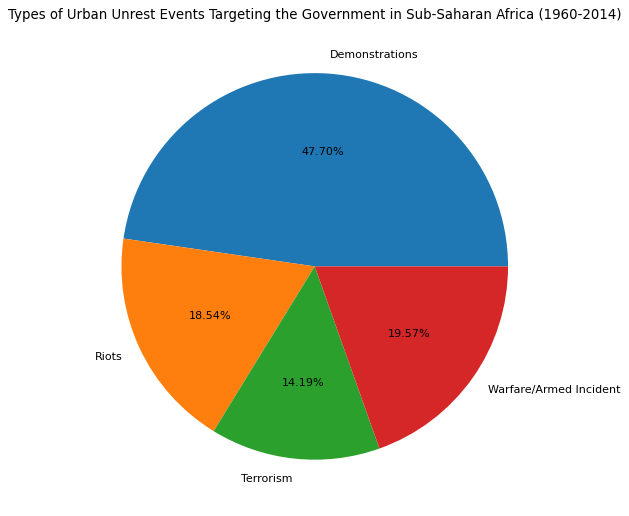



    Demonstrations  Riots  Terrorism  Warfare/Armed Incident  Total
0             373    145        111                     153    782


In [25]:
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
import pandas as pd


def execute_sql(cursor):
    cursor.execute("USE LAB8;")

    cursor.execute("WITH dems AS "
                       "(SELECT COUNT(*) AS Num "
                       "FROM Events AS e, ProblemTypes AS pt, "
                            "EventTargets AS et, Cities, Countries "
                       "WHERE e.Ptype = pt.Ptype "
                            "AND et.eventID = e.eventID "
                            "AND e.City = Cities.CityID "
                            "AND Cities.Country = Countries.ISO3 "
                            "AND Countries.Region = 'Sub-Saharan Africa' "
                            "AND YEAR(e.StartDate) >= 1960 "
                            "AND YEAR(e.StartDate) <= 2014 "
                            "AND INSTR(et.target, 'Government') > 0 "
                            "AND INSTR(pt.ProblemType, 'Demonstration') > 0), "
                   "riots AS "
                       "(SELECT COUNT(*) AS Num "
                       "FROM Events AS e, ProblemTypes AS pt, "
                            "EventTargets AS et, Cities, Countries "
                       "WHERE e.Ptype = pt.Ptype "
                            "AND et.eventID = e.eventID "
                            "AND e.City = Cities.CityID "
                            "AND Cities.Country = Countries.ISO3 "
                            "AND Countries.Region = 'Sub-Saharan Africa' "
                            "AND YEAR(e.StartDate) >= 1960 "
                            "AND YEAR(e.StartDate) <= 2014 "
                            "AND INSTR(et.target, 'Government') > 0 "
                            "AND INSTR(pt.ProblemType, 'Riot') > 0), "
                   "terr AS "
                       "(SELECT COUNT(*) AS Num "
                       "FROM Events AS e, ProblemTypes AS pt, "
                           "EventTargets AS et, Cities, Countries "
                       "WHERE e.Ptype = pt.Ptype "
                           "AND et.eventID = e.eventID "
                           "AND e.City = Cities.CityID "
                           "AND Cities.Country = Countries.ISO3 "
                           "AND Countries.Region = 'Sub-Saharan Africa' "
                           "AND YEAR(e.StartDate) >= 1960 "
                           "AND YEAR(e.StartDate) <= 2014 "
                           "AND INSTR(et.target, 'Government') > 0 "
                           "AND INSTR(pt.ProblemType, 'Terrorism') > 0), "
                   "aw AS "
                       "(SELECT COUNT(*) AS Num "
                       "FROM Events AS e, ProblemTypes AS pt, "
                           "EventTargets AS et, Cities, Countries "
                       "WHERE e.Ptype = pt.Ptype "
                           "AND et.eventID = e.eventID "
                           "AND e.City = Cities.CityID "
                           "AND Cities.Country = Countries.ISO3 "
                           "AND Countries.Region = 'Sub-Saharan Africa' "
                           "AND YEAR(e.StartDate) >= 1960 "
                           "AND YEAR(e.StartDate) <= 2014 "
                           "AND INSTR(et.target, 'Government') > 0 "
                           "AND (INSTR(pt.ProblemType, 'Armed') > 0 "
                                "OR INSTR(pt.ProblemType, 'Warfare') > 0))"
                   "SELECT dems.Num AS Demonstrations, riots.Num AS Riots, "
                        "terr.Num AS Terrorism, "
                        "aw.Num AS `Warfare/Armed Incident`, "
                        "dems.Num + riots.Num + terr.Num + aw.Num AS Total "
                   "FROM dems, riots, terr, aw;")

    records = cursor.fetchall()
    df = pd.DataFrame(records, columns=["Demonstrations", "Riots", "Terrorism", "Warfare/Armed Incident", "Total"])
    nums = [float(x) for x in df.iloc[0].tolist()][0:4]
    categories = df.columns[0:4]

    # pie chart
    plt.figure(figsize=(10, 8), dpi=80, facecolor="white")
    plt.pie(nums, labels=categories, autopct='%.2f%%')
    plt.title("Types of Urban Unrest Events Targeting the Government in Sub-Saharan Africa (1960-2014)")
    plt.show()

    print("\n\n", df)


def main():
    pwdFilename = "account.info"
    try:
        pwdFile = open(pwdFilename, "r")
        userName = pwdFile.readline().strip()
        dbName = userName
        passString = pwdFile.readline().strip()
    except FileNotFoundError as e:
        print(e)
        return 1

    hostName = "mysql.labthreesixfive.com"
    portName = "3306"

    connector = None
    cursor = None
    try:
        connector = mysql.connector.connect(host=hostName, port=portName,
                                            database=dbName, user=userName,
                                            password=passString)
        cursor = connector.cursor()
        execute_sql(cursor)

    except Error as e:
        print("connection error:", e)

    finally:
        if connector is not None and connector.is_connected():
            if cursor is not None:
                cursor.close()
            connector.close()


if __name__ == "__main__":
    main()

# Question 2 Conclusions

Demonstrations made up 47.7% of the events of urban unrest. The other half of events contained Warfare/Armed Incidents, Riots, and Terrorism, at 19.57%, 18.54%, and 14.19% respectively. Since demonstrations tend to be peaceful, or at least begin peacefully, we can conclude that at least half of the events in Sub-Saharan Africa were violent. This could be confirmed by analyzing the rate at which demonstrations had a death.

# Question 3: How many events involving “Students” as an actor occurred per Latin American country from 1960 to 2014?

I wanted to know how many events in Latin America had students as an actor. To gather the data, I used a subquery to find the Latin American countries with student actors and the number of events, and left joined it to a column of all the Latin American countries to account for the ones with zero student-involving events of urban unrest. Since there were too many countries to fit into a bar graph, I visualized the results on a histogram, with the number of events with a student actor on the x-axis and the number of countries in that bin on the y-axis.

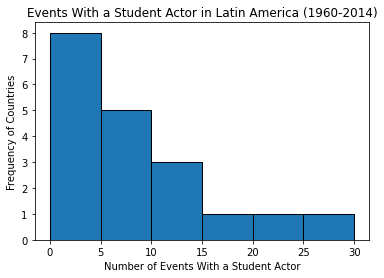



                Country  NumEvents
0                Chile         25
1              Bolivia         20
2             Colombia         17
3            Venezuela         12
4              Ecuador         10
5                 Peru         10
6            Argentina          9
7               Brazil          8
8   Dominican Republic          8
9            Guatemala          8
10              Mexico          6
11         El Salvador          4
12            Paraguay          4
13             Uruguay          3
14            Honduras          2
15              Panama          2
16               Haiti          1
17          Costa Rica          0
18                Cuba          0


In [4]:
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
import pandas as pd


def execute_sql(cursor):
    cursor.execute("USE LAB8;")

    cursor.execute("WITH with_students AS "
                       "(SELECT Countries.Country, COUNT(DISTINCT e.eventID) AS Num "
                       "FROM Events AS e, EventActors AS ea, EventTargets AS et, Cities, Countries "
                       "WHERE e.City = Cities.CityID "
                            "AND ea.eventID = e.eventID "
                            "AND et.eventID = e.eventID "
                            "AND Cities.Country = Countries.ISO3 "
                            "AND Countries.Region = 'Latin America' "
                            "AND INSTR(ea.actor, 'Students') > 0 "
                            "AND YEAR(e.StartDate) >= 1964 "
                            "AND YEAR(e.StartDate) <= 2014 "
                       "GROUP BY Countries.Country) "
                   "SELECT Country, IFNULL(Num, 0) AS NumEvents "
                   "FROM (SELECT Country FROM Countries WHERE Region = 'Latin America') AS latam "
                        "LEFT JOIN with_students USING(Country) "
                   "ORDER BY NumEvents DESC;")

    records = cursor.fetchall()
    df = pd.DataFrame(records, columns=["Country", "NumEvents"])

    bins = [0, 5, 10, 15, 20, 25, 30]
    ax = plt.subplots()[1]
    ax.set_xticks(bins)

    plt.hist(df["NumEvents"].tolist(), bins=bins, ec="black")
    plt.title("Events With a Student Actor in Latin America (1960-2014)")
    plt.xlabel("Number of Events With a Student Actor")
    plt.ylabel("Frequency of Countries")
    plt.show()

    print("\n\n", df)


def main():
    pwdFilename = "account.info"
    try:
        pwdFile = open(pwdFilename, "r")
        userName = pwdFile.readline().strip()
        dbName = userName
        passString = pwdFile.readline().strip()
    except FileNotFoundError as e:
        print(e)
        return 1

    hostName = "mysql.labthreesixfive.com"
    portName = "3306"

    connector = None
    cursor = None
    try:
        connector = mysql.connector.connect(host=hostName, port=portName,
                                            database=dbName, user=userName,
                                            password=passString)
        cursor = connector.cursor()
        execute_sql(cursor)

    except Error as e:
        print("connection error:", e)

    finally:
        if connector is not None and connector.is_connected():
            if cursor is not None:
                cursor.close()
            connector.close()


if __name__ == "__main__":
    main()

# Question 3 Conclusions

The shape of the data is right skewed---the peak is 8 countries in the bin with 0-5 events, fewer countries were in the 5-10 and 10-15 bins, and the histogram has a tail to the right up to Chile, with 25 events. To understand why some countries had so many events involving students, we could, for example, output the relevant text summaries for the events in Chile, Bolivia, and Colombia.

# Question 4: How has the average duration of an event in Asia changed from 1960 to 2014?

I wanted to find out whether the average duration of events in Asia (determined by EndDate - StartDate) has changed over the years. I excluded the events with an unknown StartDate or EndDate. In the query, I grouped all the events by the year of their StartDate and reported the average duration for each year, adding 1 to the duration so that events that started and ended on the same day would have a duration of 1 day. Then, I made a scatterplot of the durations with a regression line.

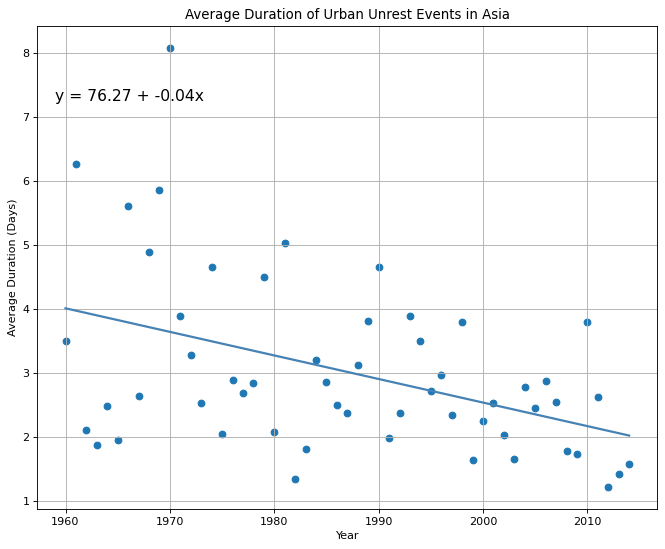



     Year AvgDuration
0   1960      3.5000
1   1961      6.2727
2   1962      2.1111
3   1963      1.8636
4   1964      2.4865
5   1965      1.9444
6   1966      5.6154
7   1967      2.6324
8   1968      4.8919
9   1969      5.8627
10  1970      8.0877
11  1971      3.8906
12  1972      3.2703
13  1973      2.5294
14  1974      4.6512
15  1975      2.0435
16  1976      2.8889
17  1977      2.6757
18  1978      2.8438
19  1979      4.4902
20  1980      2.0667
21  1981      5.0263
22  1982      1.3421
23  1983      1.8049
24  1984      3.2000
25  1985      2.8571
26  1986      2.5000
27  1987      2.3766
28  1988      3.1136
29  1989      3.8043
30  1990      4.6607
31  1991      1.9792
32  1992      2.3636
33  1993      3.8864
34  1994      3.5000
35  1995      2.7206
36  1996      2.9714
37  1997      2.3421
38  1998      3.7895
39  1999      1.6383
40  2000      2.2407
41  2001      2.5263
42  2002      2.0256
43  2003      1.6571
44  2004      2.7692
45  2005      2.4545
46  2006  

In [6]:
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
import numpy as np
import pandas as pd


def execute_sql(cursor):
    cursor.execute("USE LAB8;")

    cursor.execute("SELECT YEAR(e.StartDate) AS Year, "
                        "AVG(DATEDIFF(e.EndDate, e.StartDate) + 1) AS AvgDuration "
                   "FROM Events AS e, Cities, Countries "
                   "WHERE e.City = Cities.CityID "
                        "AND Cities.Country = Countries.ISO3 "
                        "AND Countries.Region = 'Asia' "
                        "AND YEAR(e.StartDate) >= 1960 "
                        "AND YEAR(e.EndDate) <= 2014 "
                   "GROUP BY YEAR(e.StartDate) "
                   "ORDER BY YEAR(e.StartDate);")

    records = cursor.fetchall()
    df = pd.DataFrame(records, columns=["Year", "AvgDuration"])
    years = np.array(df["Year"])
    durs = np.array([float(x) for x in df["AvgDuration"]])

    # line of best fit
    a, b = np.polyfit(years, durs, 1)

    # scatterplot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(years, durs)
    plt.plot(years, a * years + b, color="steelblue", linewidth=2)
    # linear regression equation
    plt.text(1959, 7.25, 'y = ' + '{:.2f}'.format(b) +
             ' + {:.2f}'.format(a) + 'x',
             size=14)
    plt.title("Average Duration of Urban Unrest Events in Asia")
    plt.xlabel("Year")
    plt.ylabel("Average Duration (Days)")
    plt.grid()
    plt.show()

    print("\n\n", df)


def main():
    pwdFilename = "account.info"
    try:
        pwdFile = open(pwdFilename, "r")
        userName = pwdFile.readline().strip()
        dbName = userName
        passString = pwdFile.readline().strip()
    except FileNotFoundError as e:
        print(e)
        return 1

    hostName = "mysql.labthreesixfive.com"
    portName = "3306"

    connector = None
    cursor = None
    try:
        connector = mysql.connector.connect(host=hostName, port=portName,
                                            database=dbName, user=userName,
                                            password=passString)
        cursor = connector.cursor()
        execute_sql(cursor)

    except Error as e:
        print("connection error:", e)

    finally:
        if connector is not None and connector.is_connected():
            if cursor is not None:
                cursor.close()
            connector.close()


if __name__ == "__main__":
    main()

# Question 4 Conclusions

Although the variablity of the data looks high, the average duration of events has trended downwards over time with a slope of -0.04 days per year. The intercept of 76.27 is not relevant because the earliest year included is 1960. To get a more complete picture, we should search for outliers that might increase or decrease the average duration of events in a year.

# Question 5: In the regions for which we have data (Asia, Middle East and North Africa, Sub-Saharan Africa, and Latin America), how has the percent of urban unrest events with at least one death changed from 1960 to 2014?

I wanted to know if urban unrest events have beecome more likely or less likely to have a death, from 1960 to 2014. For simplicity, I used the StartDate as the year. These years include all the events in the database, except the three events with unknown years.
To obtain the results, I used a subquery to find the total number of events per year, and another subquery to find the number of events with a death per year. I joined their results on the year, and calculated the percent of events with a death for each year.
Then, I used matplotlib to make a scatterplot with a line of best fit.

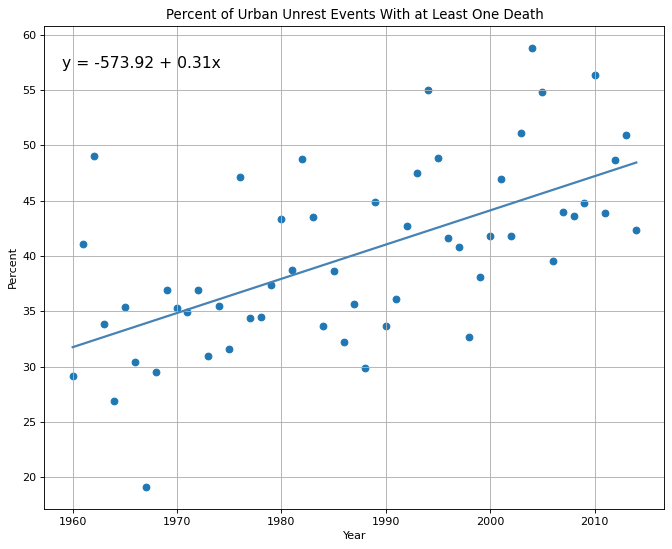



     Year  TotalEvents PercentWithDeath
0   1960           96          29.1667
1   1961           95          41.0526
2   1962           98          48.9796
3   1963           68          33.8235
4   1964           93          26.8817
5   1965           99          35.3535
6   1966          125          30.4000
7   1967          115          19.1304
8   1968          112          29.4643
9   1969          122          36.8852
10  1970          139          35.2518
11  1971          143          34.9650
12  1972          103          36.8932
13  1973           97          30.9278
14  1974          127          35.4331
15  1975          130          31.5385
16  1976          155          47.0968
17  1977          122          34.4262
18  1978          151          34.4371
19  1979          174          37.3563
20  1980          194          43.2990
21  1981          155          38.7097
22  1982          123          48.7805
23  1983          170          43.5294
24  1984          208 

In [7]:
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
import numpy as np
import pandas as pd


def execute_sql(cursor):
    cursor.execute("USE LAB8;")

    cursor.execute("WITH total AS "
                        "(SELECT YEAR(e.StartDate) AS EventYear, COUNT(*) AS NumEvents "
                        "FROM Events AS e "
                        "WHERE YEAR(e.StartDate) >= 1960 "
                            "AND YEAR(e.StartDate) <= 2014 "
                        "GROUP BY YEAR(e.StartDate)), "
                   "withdeath AS "
                        "(SELECT YEAR(e.StartDate) AS EventYear, COUNT(*) AS NumEvents "
                        "FROM Events AS e "
                        "WHERE YEAR(e.StartDate) >= 1960 "
                            "AND YEAR(e.StartDate) <= 2014 "
                            # deathFlag = 1 means there was at least one death
                            "AND e.deathFlag = 1 "
                        "GROUP BY YEAR(e.StartDate)) "
                   "SELECT total.EventYear AS Year, "
                        "total.NumEvents AS TotalEvents, "
                        "withdeath.NumEvents / total.NumEvents * 100 AS PercentWithDeath "
                    "FROM total, withdeath "
                    "WHERE total.EventYear = withdeath.EventYear "
                    "ORDER BY total.EventYear;")

    records = cursor.fetchall()
    df = pd.DataFrame(records, columns=["Year", "TotalEvents", "PercentWithDeath"])
    years = np.array(df["Year"])
    percents = np.array([float(x) for x in df["PercentWithDeath"]])

    # line of best fit
    a, b = np.polyfit(years, percents, 1)

    # scatterplot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(years, percents)
    plt.plot(years, a * years + b, color="steelblue", linewidth=2)
    # linear regression equation
    plt.text(1959, 57, 'y = ' + '{:.2f}'.format(b) +
             ' + {:.2f}'.format(a) + 'x',
             size=14)
    plt.title("Percent of Urban Unrest Events With at Least One Death")
    plt.xlabel("Year")
    plt.ylabel("Percent")
    plt.grid()
    plt.show()

    # print the table
    print("\n\n", df)


def main():
    pwdFilename = "account.info"
    try:
        pwdFile = open(pwdFilename, "r")
        userName = pwdFile.readline().strip()
        dbName = userName
        passString = pwdFile.readline().strip()
    except FileNotFoundError as e:
        print(e)
        return 1

    hostName = "mysql.labthreesixfive.com"
    portName = "3306"

    connector = None
    cursor = None
    try:
        connector = mysql.connector.connect(host=hostName, port=portName,
                                            database=dbName, user=userName,
                                            password=passString)
        cursor = connector.cursor()
        execute_sql(cursor)

    except Error as e:
        print("connection error:", e)

    finally:
        if connector is not None and connector.is_connected():
            if cursor is not None:
                cursor.close()
            connector.close()


if __name__ == "__main__":
    main()

# Question 5 Conclusions

I'd expected that the percentage of events with a death would have decreased, but the scatterplot shows that the percentage increased by 0.31% per year on average. Looking at the number of total events in the table, there were a decent number of events in all of the years, so the percents should accurately reflect the rate of deadly events for each year. Maybe this increase is related to changes in the way police handle urban unrest.